In [35]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from utils import *
from models.diffusion import *
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage import rotate
from itertools import chain
from torchvision import transforms
from torchvision.utils import save_image

from IPython.display import HTML
from IPython.display import clear_output

In [36]:
# initialize random seed
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

# choose a gpu or multiple gpus
CUDA_VISIBLE_DEVICES = 0
# cuda = True if torch.cuda.is_available() else False
# FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
# torch.set_default_tensor_type(FloatTensor)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sample_dir = './results/MNIST_CDDPM'
model_dir = './results/checkpoints/CDDPM_MNIST'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

con_train = True
load_available = False

In [37]:
joint_training = True
load_available = True
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 100
batch_size = 128
learning_rate = 1e-3

eps = 1e-6
sigma_min = 0.001
sigma_max = 10
n_steps = 10
annealed_step = 100

num_steps = 100

#制定每一步的beta
betas = torch.linspace(-6,6,num_steps)
betas = torch.sigmoid(betas)*(0.5e-2 - 1e-5)+1e-5
# betas = torch.sigmoid(betas)*(1. - 1e-5)+1e-5

#计算alpha、alpha_prod、alpha_prod_previous、alpha_bar_sqrt等变量的值
alphas = 1-betas
alphas_prod = torch.cumprod(alphas,0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(),alphas_prod[:-1]],0)

alphas_bar_sqrt = torch.sqrt(alphas_prod).to(device)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod).to(device)

assert alphas.shape==alphas_prod.shape==alphas_prod_p.shape==\
alphas_bar_sqrt.shape==one_minus_alphas_bar_log.shape\
==one_minus_alphas_bar_sqrt.shape
print("all the same shape",betas.shape)

all the same shape torch.Size([100])


In [38]:
# MNIST dataset
dataset = torchvision.datasets.MNIST(root='../../Data/MNIST/',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [39]:
vae = VAE(input_size=image_size, h_dim=h_dim, z_dim=z_dim, type='ce').to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

# sn = SN_Model(device, n_steps, sigma_min, sigma_max, dim=z_dim, p = 0.3)
sn = MLPDiffusion(num_steps, dim=z_dim, num_classes=10).to(device)
sn_optim = torch.optim.Adam(sn.parameters(), lr = 1e-3)
joint_optim = torch.optim.Adam(params=chain(vae.parameters(), sn.parameters()))

In [40]:
# Start training
if con_train:
    for epoch in range(num_epochs):
        for i, (x, y) in enumerate(data_loader):
            x = x.to(device).view(-1, image_size)
            y = y.to(device)
            if joint_training:
                mu, log_var = vae.encode(x)
                z = vae.reparameterize(mu, log_var)
                x_reconst = vae.decode(z)
                # Compute reconstruction loss and kl divergence
                reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
                kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
                loss_sn = diffusion_loss_fn(sn, z,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps,y)
                loss = loss_sn + reconst_loss + kl_div

                joint_optim.zero_grad()
                loss.backward()
                joint_optim.step()
            else:
                #============= First Stage: Update VAE ==============#
                # Forward pass
                x_reconst, mu, log_var = vae(x)
                # Compute reconstruction loss and kl divergence
                # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
                reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
                kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
                
                # Backprop and optimize
                vae_loss = reconst_loss + kl_div
                vae_optimizer.zero_grad()
                vae_loss.backward()
                vae_optimizer.step()

                #============= Second Stage: Update SN ==============#
                mu, log_var = vae.encode(x)
                z = vae.reparameterize(mu, log_var)

                loss_sn = sn.loss(z)
                vae_optimizer.zero_grad()
                sn_optim.zero_grad()
                loss_sn.backward()
                sn_optim.step()

            if (i+1) % 100 == 0:
                print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Diffuse loss: {:.4f}"
                    .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item(), loss_sn.item()))

        with torch.no_grad():
            # Save the sampled images
            z = torch.randn(x.shape[0], z_dim).to(device)
            out = vae.decode(z).view(-1, 1, 28, 28)
            x_concat = torch.cat([x.view(-1, 1, 28, 28), out], dim=3)
            save_image(x_concat, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

            # Save the reconstructed images
            out, _, _ = vae(x)
            x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
            save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

            # Save the diffused images
            # dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, sn, device, eps=eps)
            # z_ = forward_proc(z, sigma_min, sigma_max, n_steps, device=device, only_final=True)
            # sample = dynamic.sampling(x.shape[0], z_dim, sample=z_, only_final=True)

            z_ = alphas_bar_sqrt[-1]*z + one_minus_alphas_bar_sqrt[-1]*torch.randn_like(z)
            sample = ddim_sample(sn, num_steps=num_steps, batch_size=x.shape[0], dim=z_dim, x_T=z_, y=y)
            # sample = dynamic.sampling(x.shape[0], z_dim, only_final=True)
            out = vae.decode(sample).view(-1, 1, 28, 28)
            x_concat = torch.cat([x.view(-1, 1, 28, 28), out], dim=3)
            save_image(x_concat, os.path.join(sample_dir, 'diffuse-{}.png'.format(epoch+1)))
    torch.save({'sn_state':sn.state_dict(), 'vae_state':vae.state_dict()}, model_dir+'ckpt.pth')

Epoch[1/100], Step [100/469], Reconst Loss: 22550.7305, KL Div: 1418.4036, Diffuse loss: 0.9838
Epoch[1/100], Step [200/469], Reconst Loss: 18186.1797, KL Div: 1949.6438, Diffuse loss: 1.0180
Epoch[1/100], Step [300/469], Reconst Loss: 16675.2324, KL Div: 2427.6223, Diffuse loss: 0.9524
Epoch[1/100], Step [400/469], Reconst Loss: 14917.6777, KL Div: 2479.7271, Diffuse loss: 0.9868
Epoch[2/100], Step [100/469], Reconst Loss: 13648.2979, KL Div: 2775.5820, Diffuse loss: 0.9994
Epoch[2/100], Step [200/469], Reconst Loss: 12555.3984, KL Div: 2859.2539, Diffuse loss: 1.0121
Epoch[2/100], Step [300/469], Reconst Loss: 12551.6416, KL Div: 2819.7383, Diffuse loss: 0.9819
Epoch[2/100], Step [400/469], Reconst Loss: 12318.3936, KL Div: 2991.9700, Diffuse loss: 1.0137
Epoch[3/100], Step [100/469], Reconst Loss: 12030.7480, KL Div: 2971.3962, Diffuse loss: 0.9923
Epoch[3/100], Step [200/469], Reconst Loss: 11748.7734, KL Div: 2992.6899, Diffuse loss: 1.0109
Epoch[3/100], Step [300/469], Reconst Lo

### Load the model if available


In [41]:
if load_available:
    try:
        ckpt = torch.load(model_dir+'ckpt.pth')
        sn.load_state_dict(ckpt['sn_state'])
        vae.load_state_dict(ckpt['vae_state'])
    except:
        print('No checkpoint found')

In [42]:
_, (x, y) = next(enumerate(data_loader))
x = x.to(device)
y = y.to(device)

### Generate samples

In [43]:
import math

def ani_imshow(sample, sampling_number = 64):

    row_number = int(math.sqrt(sampling_number))
    col_number = int(math.sqrt(sampling_number))
    sample = sample[:sampling_number].detach().cpu().numpy()
    shape = sample.shape
    show_sample = np.zeros([row_number * shape[2], col_number * shape[3] ]).astype(np.float32)
    for row in range(row_number):
        for col in range(col_number):
            sample_ = sample[row + col * row_number][0]
            show_sample[ row * shape[2] : (row+1) * shape[2], col * shape[3] : (col+1) * shape[3] ] = (sample_ - sample_.min()) / (sample_.max() - sample_.min()) * 255

    show_sample = show_sample.astype(np.uint8)

    return show_sample

(-0.5, 307.5, 307.5, -0.5)

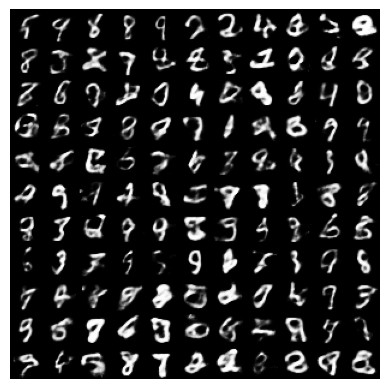

In [44]:
sample = ddim_sample(sn, num_steps=num_steps, batch_size=x.shape[0], dim=z_dim)
# sample = dynamic.sampling(x.shape[0], z_dim, only_final=True)
data_sample = vae.decode(sample).view(-1, 1, 28, 28)

plt.imshow(ani_imshow(data_sample, sampling_number = sample.shape[0]), animated=True, cmap = 'gray')
plt.axis('off')

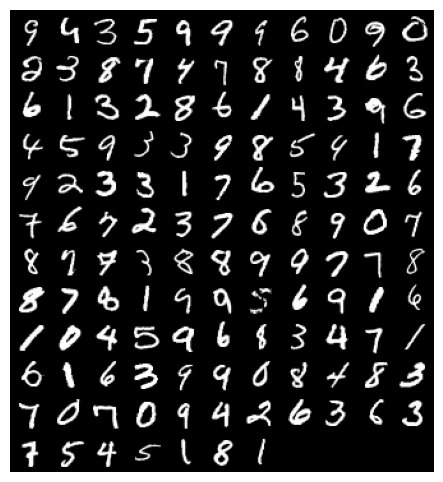

In [45]:
# original data
from torchvision.utils import make_grid

sample_grid = make_grid(x.view(-1, 1, 28, 28), nrow=int(np.sqrt(x.shape[0])))

select_t = 0.3

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [46]:
# forward process
mu, log_var = vae.encode(x.view(-1, image_size))
z = vae.reparameterize(mu, log_var)

In [47]:
z_ = alphas_bar_sqrt[-1]*z + one_minus_alphas_bar_sqrt[-1]*torch.randn_like(z)

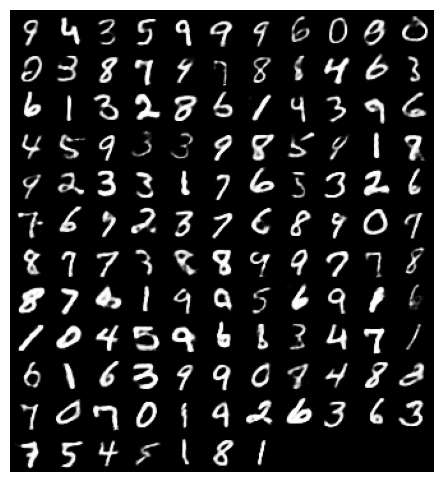

In [48]:
sample = ddim_sample(sn, num_steps=num_steps, dim=z_dim, x_T=z_, y=y)
# sample = dynamic.sampling(x.shape[0], z_dim, only_final=True)
data_sample = vae.decode(sample).view(-1, 1, 28, 28).detach()

sample_grid = make_grid(data_sample, nrow=int(np.sqrt(data_sample.shape[0])))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

/tmp/ipykernel_6795/772263847.py:9: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_list.append(ssim(x.view(-1, 28, 28).cpu().numpy(), data_sample.view(-1, 28, 28).cpu().numpy(), data_range=1.0, multichannel=False))


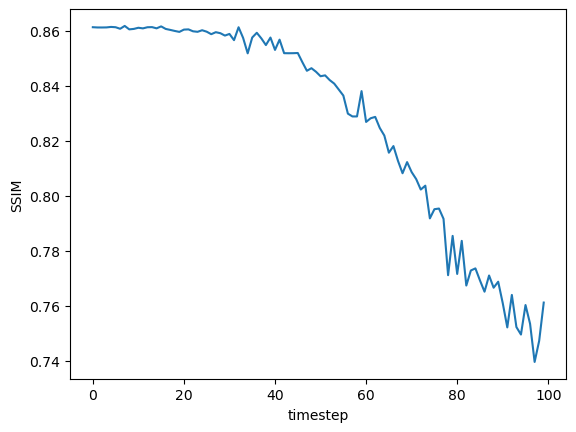

In [49]:
from skimage.metrics import structural_similarity as ssim

ssim_list = []

for t in range(100):
    z_ = alphas_bar_sqrt[t]*z + one_minus_alphas_bar_sqrt[t]*torch.randn_like(z)
    sample = ddim_sample(sn, num_steps=num_steps, dim=z_dim, x_T=z_, y=y)
    data_sample = vae.decode(sample).view(-1, 1, 28, 28).detach()
    ssim_list.append(ssim(x.view(-1, 28, 28).cpu().numpy(), data_sample.view(-1, 28, 28).cpu().numpy(), data_range=1.0, multichannel=False))

plt.plot(ssim_list)
plt.xlabel('timestep')
plt.ylabel('SSIM')
plt.show()

In [50]:
# FID 
from piq import FID, ssim, psnr, MSID, LPIPS

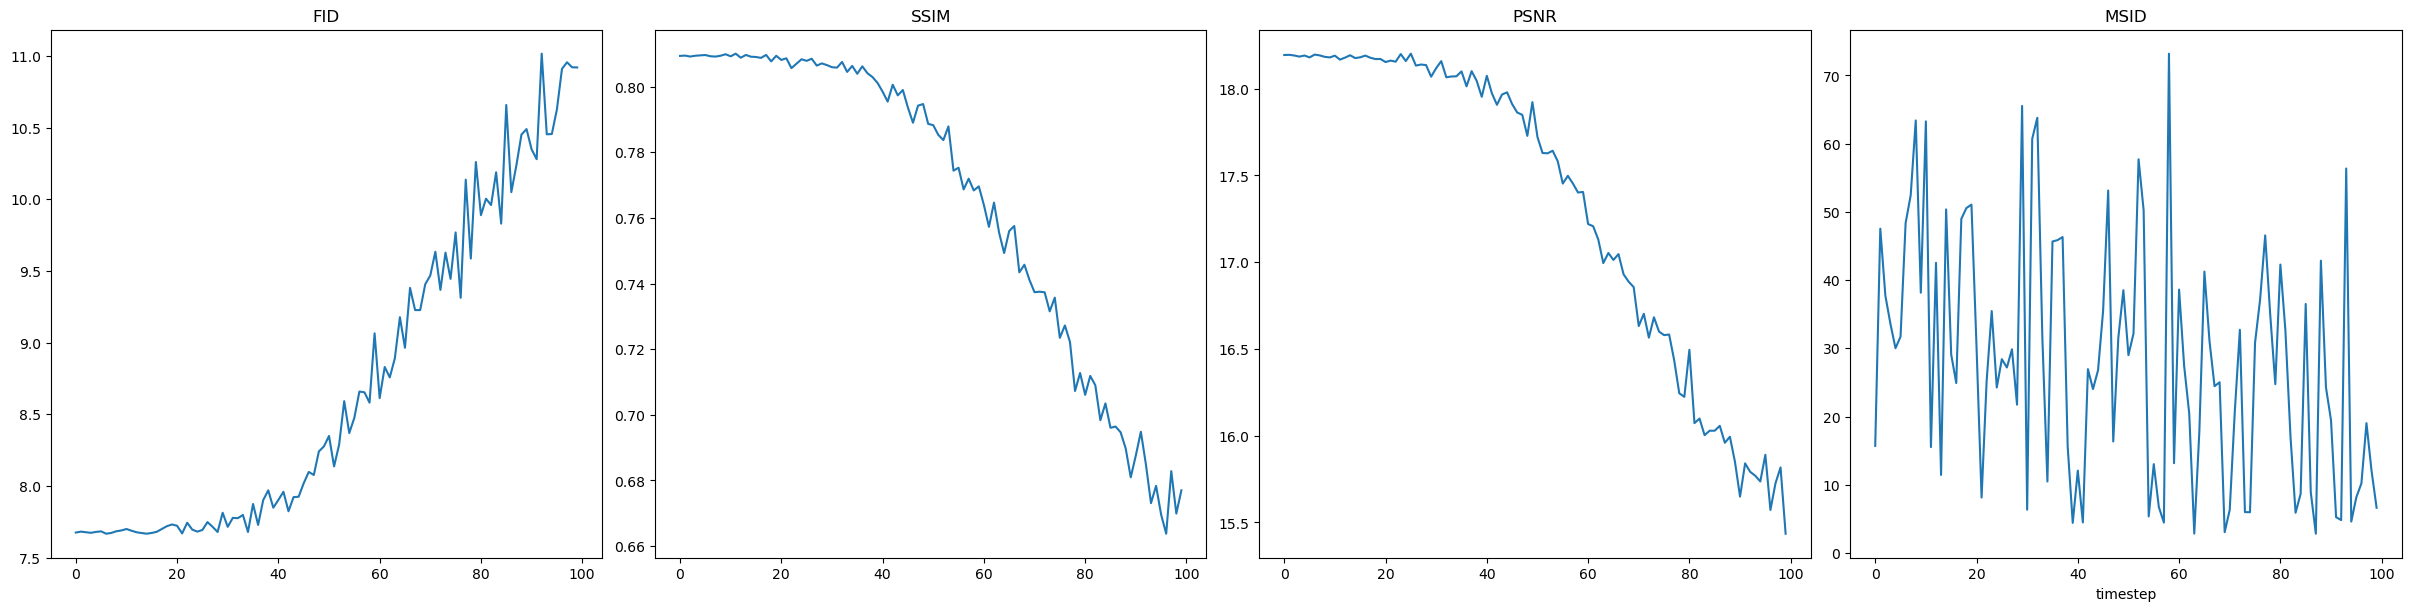

In [51]:
metrics = ['FID', 'SSIM', 'PSNR', 'MSID']
fig, axs = plt.subplots(1, len(metrics), figsize=(len(metrics) * 6, 6), constrained_layout = True)
i = 0
for metric in metrics:
    if metric == 'FID':
        metric_fn = FID()
    elif metric == 'SSIM':
        metric_fn = ssim
    elif metric == 'PSNR':
        metric_fn = psnr
    elif metric == 'MSID':
        metric_fn = MSID()
    
    idx_list = []

    if metric in ['MSID', 'FID']:
        for t in range(100):
            z_ = alphas_bar_sqrt[t]*z + one_minus_alphas_bar_sqrt[t]*torch.randn_like(z)
            sample = ddim_sample(sn, num_steps=num_steps, dim=z_dim, x_T=z_, y=y)
            data_sample = vae.decode(sample).view(-1, 1, 28, 28).detach()
            idx_list.append(metric_fn(x.view(-1, 28*28), data_sample.view(-1, 28*28)).item())
    else:
        for t in range(100):
            z_ = alphas_bar_sqrt[t]*z + one_minus_alphas_bar_sqrt[t]*torch.randn_like(z)
            sample = ddim_sample(sn, num_steps=num_steps, dim=z_dim, x_T=z_, y=y)
            data_sample = vae.decode(sample).view(-1, 1, 28, 28).detach()
            idx_list.append(metric_fn(x, data_sample).item())
    
    axs[i].plot(idx_list)
    axs[i].set_title(metric)
    i = i + 1
plt.xlabel('timestep')
plt.show()